In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join('..')))

from src.loading import DataLoader
from src.cleaning import DataCleaner
from src.weighting import DataWeighter
from src.similarity_gpu import NetworkBuilder
from src.clustering import NetworkClusterer
from src.enrichment import GeneEnricher

sns.set_theme(style="whitegrid", palette="muted")

## Step 1 — Caricamento dati

In [2]:
dl = DataLoader()
BP, CC, MF, HPO, DepthBP, DepthCC, DepthMF = dl.load_and_prepare_data()

Loading DATA from ../data/raw/
[OK] BP data loaded: (5183, 9873)
[OK] CC data loaded: (5183, 1478)
[OK] MF data loaded: (5183, 3258)
[OK] HPO data loaded: (5183, 10185)
[OK] DepthBP data loaded: (1, 9566)
[OK] DepthCC data loaded: (1, 1453)
[OK] DepthMF data loaded: (1, 3157)


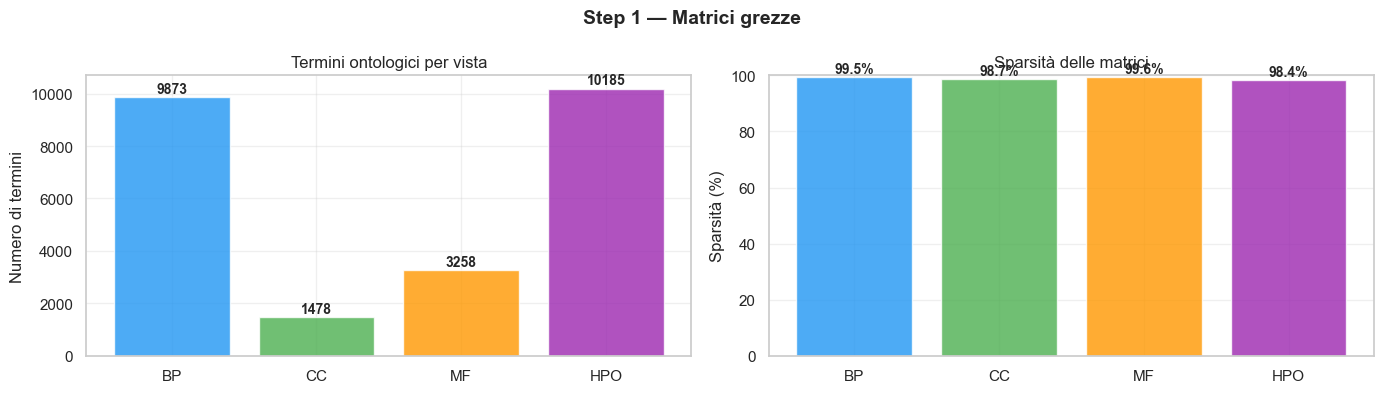

In [3]:
raw_shapes = {
    'BP': BP.shape, 'CC': CC.shape, 'MF': MF.shape, 'HPO': HPO.shape,
    'DepthBP': DepthBP.shape, 'DepthCC': DepthCC.shape, 'DepthMF': DepthMF.shape
}

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Step 1 — Matrici grezze', fontsize=14, fontweight='bold')

views = ['BP', 'CC', 'MF', 'HPO']
genes = [raw_shapes[v][0] for v in views]
terms = [raw_shapes[v][1] for v in views]

ax = axes[0]
bars = ax.bar(views, terms, color=['#2196F3', '#4CAF50', '#FF9800', '#9C27B0'], alpha=0.8)
ax.set_ylabel('Numero di termini')
ax.set_title('Termini ontologici per vista')
for bar, val in zip(bars, terms):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.grid(True, alpha=0.3)

# Sparsity
ax2 = axes[1]
sparsity = []
for name, df in [('BP', BP), ('CC', CC), ('MF', MF), ('HPO', HPO)]:
    nonzero = (df > 0).sum().sum()
    total = df.shape[0] * df.shape[1]
    sparsity.append(100 * (1 - nonzero / total))
bars2 = ax2.bar(views, sparsity, color=['#2196F3', '#4CAF50', '#FF9800', '#9C27B0'], alpha=0.8)
ax2.set_ylabel('Sparsità (%)')
ax2.set_title('Sparsità delle matrici')
for bar, val in zip(bars2, sparsity):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 2 — Pulizia e filtraggio

In [4]:
raw_term_counts = {'BP': BP.shape[1], 'CC': CC.shape[1], 'MF': MF.shape[1], 'HPO': HPO.shape[1]}
raw_gene_count = BP.shape[0]

dc = DataCleaner(BP, CC, MF, HPO, DepthBP, DepthCC, DepthMF)
BP, CC, MF, HPO, DepthBP, DepthCC, DepthMF = dc.clean_all()

[OK] BP data cleaned: (4142, 5749)
[OK] CC data cleaned: (4142, 839)
[OK] MF data cleaned: (4142, 1265)
[OK] HPO data cleaned: (4142, 5874)
[OK] DepthBP data cleaned: (1, 5648)
[OK] DepthCC data cleaned: (1, 827)
[OK] DepthMF data cleaned: (1, 1245)


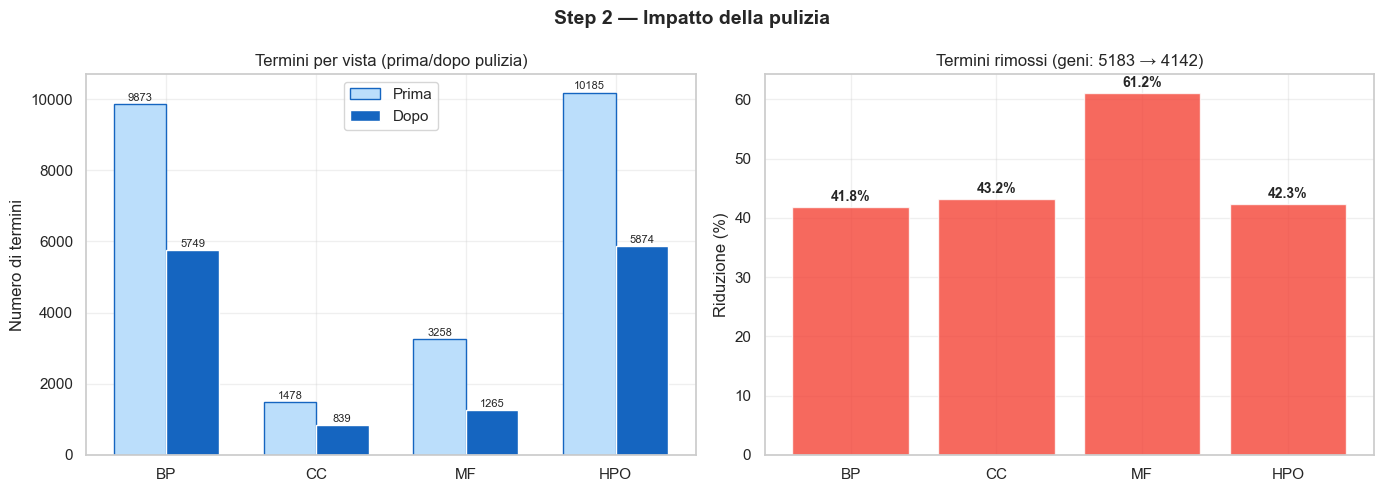

In [5]:
clean_term_counts = {'BP': BP.shape[1], 'CC': CC.shape[1], 'MF': MF.shape[1], 'HPO': HPO.shape[1]}
clean_gene_count = BP.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Step 2 — Impatto della pulizia', fontsize=14, fontweight='bold')

# Terms before/after
ax = axes[0]
views = ['BP', 'CC', 'MF', 'HPO']
x = np.arange(len(views))
w = 0.35
raw_vals = [raw_term_counts[v] for v in views]
clean_vals = [clean_term_counts[v] for v in views]

bars_raw = ax.bar(x - w/2, raw_vals, w, label='Prima', color='#BBDEFB', edgecolor='#1565C0')
bars_clean = ax.bar(x + w/2, clean_vals, w, label='Dopo', color='#1565C0')
ax.set_xticks(x); ax.set_xticklabels(views)
ax.set_ylabel('Numero di termini')
ax.set_title('Termini per vista (prima/dopo pulizia)')
ax.legend()
ax.grid(True, alpha=0.3)
for bar, val in zip(bars_raw, raw_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
            str(val), ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars_clean, clean_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
            str(val), ha='center', va='bottom', fontsize=8)

# Reduction percentages
ax2 = axes[1]
reductions = [100 * (1 - clean_term_counts[v] / raw_term_counts[v]) for v in views]
colors = ['#F44336' if r > 40 else '#FF9800' if r > 20 else '#4CAF50' for r in reductions]
bars3 = ax2.bar(views, reductions, color=colors, alpha=0.8)
ax2.set_ylabel('Riduzione (%)')
ax2.set_title(f'Termini rimossi (geni: {raw_gene_count} → {clean_gene_count})')
for bar, val in zip(bars3, reductions):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3 — Pesatura TF-IDF depth-aware

In [6]:
dw = DataWeighter(BP, CC, MF, HPO, DepthBP, DepthCC, DepthMF)
BP_tfidf, CC_tfidf, MF_tfidf, HPO_tfidf = dw.transform_all()

=== Depth-Weighted TF-IDF ===

[BP] Applying depth weighting...
  [DEPTH] 101/5749 terms missing from depth file -> imputed with median depth (5.0)
[BP] Applying TF-IDF...
[OK] BP transformed: (4142, 5749)

[CC] Applying depth weighting...
  [DEPTH] 12/839 terms missing from depth file -> imputed with median depth (4.0)
[CC] Applying TF-IDF...
[OK] CC transformed: (4142, 839)

[MF] Applying depth weighting...
  [DEPTH] 20/1265 terms missing from depth file -> imputed with median depth (4.0)
[MF] Applying TF-IDF...
[OK] MF transformed: (4142, 1265)

[HPO] No depth file available — applying plain TF-IDF...
[OK] HPO transformed: (4142, 5874)

[SAVED] All TF-IDF matrices written to ../data/processed/


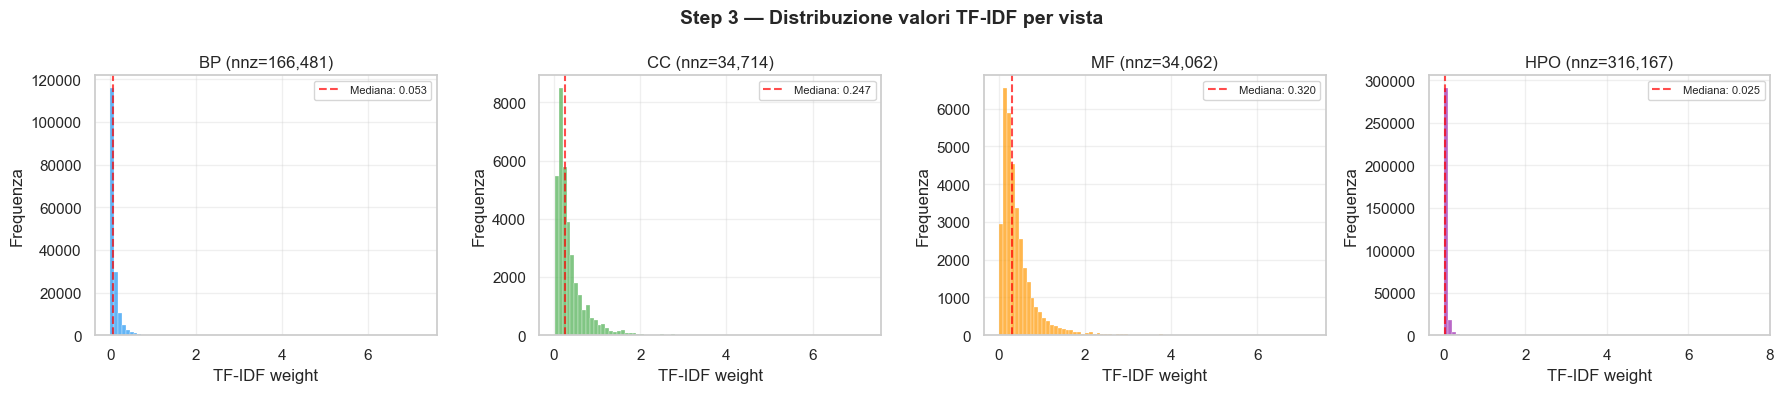

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.suptitle('Step 3 — Distribuzione valori TF-IDF per vista', fontsize=14, fontweight='bold')

for ax, (name, df), color in zip(axes,
    [('BP', BP_tfidf), ('CC', CC_tfidf), ('MF', MF_tfidf), ('HPO', HPO_tfidf)],
    ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0']):

    # Flatten non-zero values only
    vals = df.values.flatten()
    vals = vals[vals > 0]
    ax.hist(vals, bins=80, color=color, alpha=0.7, edgecolor='white', linewidth=0.3)
    ax.set_xlabel('TF-IDF weight')
    ax.set_ylabel('Frequenza')
    ax.set_title(f'{name} (nnz={len(vals):,})')
    ax.axvline(np.median(vals), color='red', ls='--', alpha=0.7, label=f'Mediana: {np.median(vals):.3f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4 — Similarity Network Fusion

In [8]:
snf_builder = NetworkBuilder(BP_tfidf, CC_tfidf, MF_tfidf, HPO_tfidf)
fused = snf_builder.build_and_fuse()

=== Similarity Network Fusion (device: mps) ===

[BP] Feature matrix: (4142, 5749)
[CC] Feature matrix: (4142, 839)
[MF] Feature matrix: (4142, 1265)
[HPO] Feature matrix: (4142, 5874)

[SNF] Fusing 4 networks (K=20, t=20 iterations)...
[OK] Fused network: (4142, 4142)
[SAVED] ../data/processed/fused_network.csv


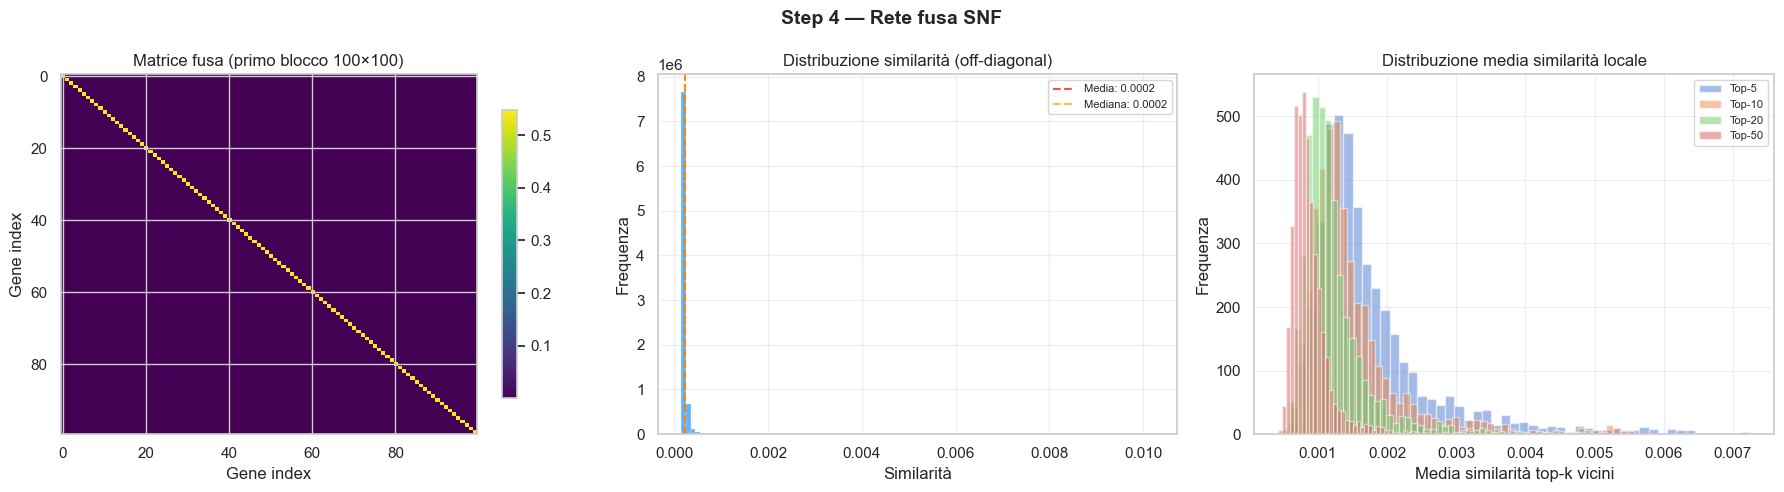

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Step 4 — Rete fusa SNF', fontsize=14, fontweight='bold')

# Sample heatmap (100x100 block for readability)
ax = axes[0]
sample_size = min(100, fused.shape[0])
sample = fused.values[:sample_size, :sample_size]
im = ax.imshow(sample, cmap='viridis', aspect='auto')
ax.set_title(f'Matrice fusa (primo blocco {sample_size}×{sample_size})')
ax.set_xlabel('Gene index'); ax.set_ylabel('Gene index')
plt.colorbar(im, ax=ax, shrink=0.8)

# Similarity distribution (off-diagonal)
ax2 = axes[1]
mask_upper = np.triu_indices_from(fused.values, k=1)
offdiag = fused.values[mask_upper]
ax2.hist(offdiag, bins=100, color='#2196F3', alpha=0.7, edgecolor='white', linewidth=0.3)
ax2.axvline(np.mean(offdiag), color='red', ls='--', alpha=0.7,
            label=f'Media: {np.mean(offdiag):.4f}')
ax2.axvline(np.median(offdiag), color='orange', ls='--', alpha=0.7,
            label=f'Mediana: {np.median(offdiag):.4f}')
ax2.set_xlabel('Similarità'); ax2.set_ylabel('Frequenza')
ax2.set_title('Distribuzione similarità (off-diagonal)')
ax2.legend(fontsize=8); ax2.grid(True, alpha=0.3)

# Top-k neighbors per gene (avg similarity)
ax3 = axes[2]
k_vals = [5, 10, 20, 50]
for k in k_vals:
    top_k_means = []
    for i in range(fused.shape[0]):
        row = np.sort(fused.values[i])[::-1]
        top_k_means.append(np.mean(row[1:k+1]))  # exclude self
    ax3.hist(top_k_means, bins=50, alpha=0.5, label=f'Top-{k}')
ax3.set_xlabel('Media similarità top-k vicini'); ax3.set_ylabel('Frequenza')
ax3.set_title('Distribuzione media similarità locale')
ax3.legend(fontsize=8); ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5 — Clustering (UMAP 10D + HDBSCAN)

In [10]:
nc = NetworkClusterer(fused)
clusters_df = nc.run_and_save(viz_method='umap', clus_method='hdbscan',
                  n_components=2, n_neighbors=15,
                  min_cluster_size=10, min_samples=2,
                  cluster_dims=10, cluster_n_neighbors=5,
                  cluster_selection_method='leaf')

=== Inizio Fase di Clustering ===
[Clustering] UMAP 10D + HDBSCAN
  [UMAP] Proiezione a 10D (n_neighbors=5)...


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[OK] Clustering completato: 198 moduli, 600 geni rumore (14.5%)
=== Validazione ===
Silhouette Score: 0.5751 (su embedding 10D, escluso rumore)

[Visualizzazione] Metodo: UMAP | Componenti: 2


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Marker] Identificazione top-3 geni rappresentativi per cluster
[OK] Marker identificati per 198 cluster
[SAVED] Risultati esportati in: ../data/results/gene_clusters_final.csv


/var/folders/6m/tldlm3j53p1dhx1qwnp0hkcr0000gn/T/ipykernel_24245/2206775669.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', min(n_clusters, 20))


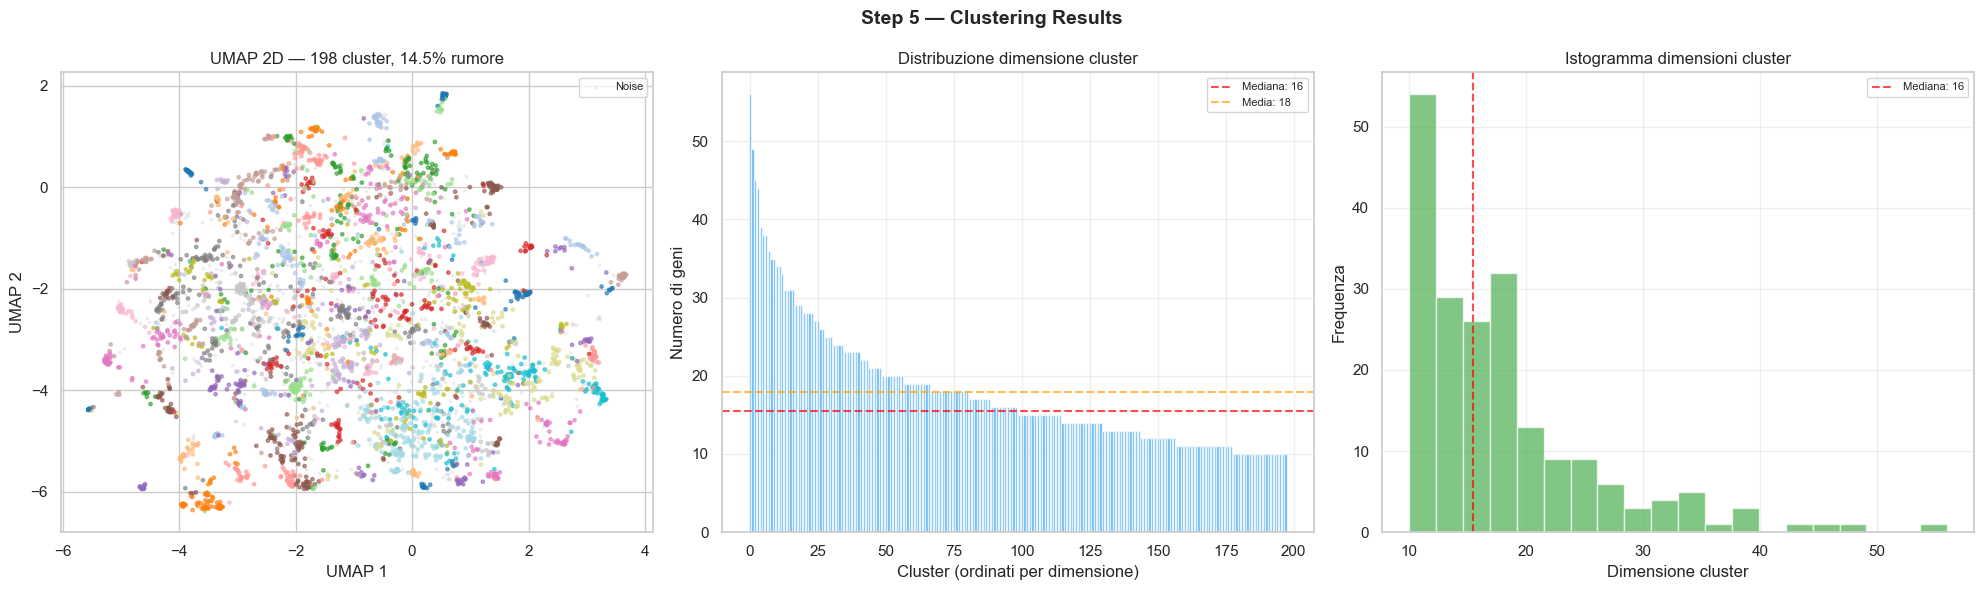

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Step 5 — Clustering Results', fontsize=14, fontweight='bold')

labels = clusters_df['Cluster'].values
mask = labels != -1
noise_mask = labels == -1
n_clusters = len(set(labels) - {-1})
noise_pct = 100 * noise_mask.sum() / len(labels)

# 1. UMAP scatter colored by cluster
ax = axes[0]
cmap = plt.cm.get_cmap('tab20', min(n_clusters, 20))
ax.scatter(clusters_df.loc[noise_mask, 'Dim_1'], clusters_df.loc[noise_mask, 'Dim_2'],
           c='lightgray', s=3, alpha=0.3, label='Noise', rasterized=True)
scatter = ax.scatter(clusters_df.loc[mask, 'Dim_1'], clusters_df.loc[mask, 'Dim_2'],
                     c=labels[mask], cmap=cmap, s=6, alpha=0.6, rasterized=True)
ax.set_xlabel('UMAP 1'); ax.set_ylabel('UMAP 2')
ax.set_title(f'UMAP 2D — {n_clusters} cluster, {noise_pct:.1f}% rumore')
ax.legend(loc='upper right', fontsize=8)

# 2. Cluster size distribution
ax2 = axes[1]
cluster_sizes = pd.Series(labels[mask]).value_counts().sort_values(ascending=False)
ax2.bar(range(len(cluster_sizes)), cluster_sizes.values, color='#2196F3', alpha=0.7)
ax2.axhline(cluster_sizes.median(), color='red', ls='--', alpha=0.7,
            label=f'Mediana: {cluster_sizes.median():.0f}')
ax2.axhline(cluster_sizes.mean(), color='orange', ls='--', alpha=0.7,
            label=f'Media: {cluster_sizes.mean():.0f}')
ax2.set_xlabel('Cluster (ordinati per dimensione)')
ax2.set_ylabel('Numero di geni')
ax2.set_title('Distribuzione dimensione cluster')
ax2.legend(fontsize=8); ax2.grid(True, alpha=0.3)

# 3. Cluster size histogram
ax3 = axes[2]
ax3.hist(cluster_sizes.values, bins=20, color='#4CAF50', alpha=0.7, edgecolor='white')
ax3.set_xlabel('Dimensione cluster'); ax3.set_ylabel('Frequenza')
ax3.set_title('Istogramma dimensioni cluster')
ax3.axvline(cluster_sizes.median(), color='red', ls='--', alpha=0.7,
            label=f'Mediana: {cluster_sizes.median():.0f}')
ax3.legend(fontsize=8); ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6 — Arricchimento funzionale

In [12]:
enricher = GeneEnricher(
    clusters_path='../data/results/gene_clusters_final.csv',
    fused_path='../data/processed/fused_network.csv',
    output_dir='../data/results/',
    marker_genes=nc.marker_genes
)
enricher.run(k=15)

[OK] Cluster caricati: 4142 geni, 199 cluster unici
=== Enrichment Pipeline ===


=== Annotazione Genica (MyGene.info) ===

[INFO] 4142 geni da annotare in 5 batch
  Batch 1/5 completato
  Batch 2/5 completato
  Batch 3/5 completato
  Batch 4/5 completato
  Batch 5/5 completato

[OK] Annotazione completata: 4142 trovati, 0 non trovati

=== Enrichment dei Cluster (g:Profiler) ===

[INFO] 198 cluster da analizzare (escluso rumore)
  Progresso: 50/198 cluster elaborati
  Progresso: 100/198 cluster elaborati
  Progresso: 150/198 cluster elaborati

[OK] Enrichment completato: 198 arricchiti, 0 saltati (<3 geni), 0 falliti

=== Costruzione Rete k-NN ===

[INFO] Matrice fusa caricata: (4142, 4142)
[OK] 62130 archi generati (k=15)
[SAVED] Edge list esportata in: ../data/results/knn_edges.csv

=== Salvataggio Risultati ===

[SAVED] Dati arricchiti esportati in: ../data/results/enriched_data.json

=== Pipeline Completata ===
  Geni annotati:    4142
  Cluster arricchiti: 198
  Archi k-NN:       

/var/folders/6m/tldlm3j53p1dhx1qwnp0hkcr0000gn/T/ipykernel_24245/2086518916.py:49: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/6m/tldlm3j53p1dhx1qwnp0hkcr0000gn/T/ipykernel_24245/2086518916.py:49: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


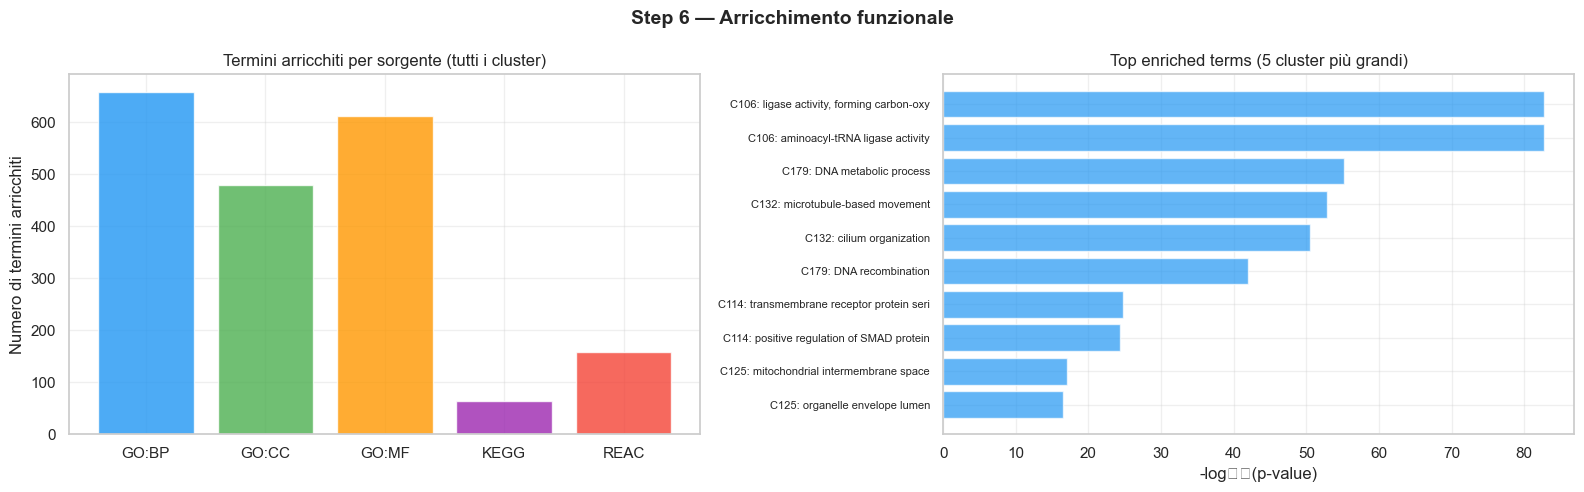

In [13]:
import json

with open('../data/results/enriched_data.json') as f:
    enriched = json.load(f)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Step 6 — Arricchimento funzionale', fontsize=14, fontweight='bold')

# 1. Enrichment source distribution across all clusters
source_counts = {}
for cid, cdata in enriched['clusters'].items():
    for term in cdata.get('enrichment', []):
        src = term['source']
        source_counts[src] = source_counts.get(src, 0) + 1

ax = axes[0]
sources = sorted(source_counts.keys())
counts = [source_counts[s] for s in sources]
colors = {'GO:BP': '#2196F3', 'GO:CC': '#4CAF50', 'GO:MF': '#FF9800',
          'KEGG': '#9C27B0', 'REAC': '#F44336'}
bar_colors = [colors.get(s, '#607D8B') for s in sources]
ax.bar(sources, counts, color=bar_colors, alpha=0.8)
ax.set_ylabel('Numero di termini arricchiti')
ax.set_title('Termini arricchiti per sorgente (tutti i cluster)')
ax.grid(True, alpha=0.3)

# 2. Top enriched terms from the 5 largest clusters
ax2 = axes[1]
largest = sorted(enriched['clusters'].items(),
                 key=lambda x: x[1]['size'], reverse=True)[:5]
top_terms = []
for cid, cdata in largest:
    for term in cdata.get('enrichment', [])[:2]:  # top 2 per cluster
        label = f"C{cid}: {term['term_name'][:35]}"
        top_terms.append((label, -np.log10(max(term['p_value'], 1e-300)), cid))

if top_terms:
    top_terms.sort(key=lambda x: x[1], reverse=True)
    labels_plot = [t[0] for t in top_terms]
    values_plot = [t[1] for t in top_terms]
    ax2.barh(range(len(labels_plot)), values_plot, color='#2196F3', alpha=0.7)
    ax2.set_yticks(range(len(labels_plot)))
    ax2.set_yticklabels(labels_plot, fontsize=8)
    ax2.set_xlabel('-log₁₀(p-value)')
    ax2.set_title('Top enriched terms (5 cluster più grandi)')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()